## Name : Kishor Kumar Bhaumik
### Student ID: 862542862

# RAID Text Detector Pipeline: A Fine-Tuning and QLoRA Example

This notebook provides a complete pipeline for training a text classification model to detect AI-generated text, specifically focusing on the RAID (Robustness to AI-Generated Text Detection) dataset. It demonstrates how to:

1.  **Load and prepare datasets** from Hugging Face, including filtering, sampling, and tokenization.
2.  **Define a PyTorch Lightning module** (`TextClassifier`) for training and evaluation.
3.  **Implement QLoRA (Quantized Low-Rank Adaptation)** for efficient fine-tuning of large language models, allowing training on consumer-grade GPUs.
4.  **Set up a PyTorch Lightning DataModule** for efficient data loading.
5.  **Orchestrate the training and testing process** using PyTorch Lightning's `Trainer`.
6.  **Log metrics** (optional, using Weights & Biases) and save the trained model.

The goal is to build a robust detector that can distinguish between human-written and AI-generated text, even when the AI text has been subjected to various adversarial attacks.

## 1. Setup and Configuration

First, we import the necessary libraries and define a `Config` dataclass to manage all hyperparameters and settings for our experiment. This makes it easy to modify parameters and keeps the code organized.

**Key configurations include:**

* `experiment_name`, `wandb_project`, `wandb_run_name`: For Weights & Biases logging.
* `seed`: For reproducibility.
* `model_name`: The base pre-trained model (e.g., `bert-base-uncased`).
* **QLoRA Parameters (`use_qlora`, `lora_r`, `lora_alpha`, `lora_dropout`, `target_modules`, `load_in_4bit`, etc.):** These control the QLoRA fine-tuning process, enabling efficient training by quantizing the model and only training a small number of additional parameters.
* `train_percent_ai`, `train_percent_human`, `test_percent_ai`, `test_percent_human`: Controls the percentage of data to use for training/testing.
* `warmup_steps`, `use_scheduler`: For learning rate scheduling.
* `max_length`, `batch_size`, `num_epochs`, `learning_rate`, `weight_decay`: Standard training parameters.
* `gpus`: Specifies which GPU devices to use.
* `tokenizer_cache_path`, `tokenized_data_path`, `save_dir`: Paths for caching and saving assets.

In [1]:
import os
import torch
import random
import numpy as np
from dataclasses import dataclass, field
from datasets import load_dataset, DatasetDict, concatenate_datasets, load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, confusion_matrix
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from pathlib import Path
import warnings
import argparse
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('medium')



# ------------------------------
# Config
# ------------------------------
@dataclass
class Config:
    experiment_name: str = "BRERT-Base"
    seed: int = 12
    model_name: str = "bert-base-uncased"
    use_wandb: bool = False
    
    # QLoRA specific parameters
    use_qlora: bool = False
    lora_r: int = 8
    lora_alpha: int = 16
    lora_dropout: float = 0.2
    target_modules: list = field(default_factory=lambda: ["query", "value"])  # Adjust based on your model
    load_in_4bit: bool = True
    bnb_4bit_use_double_quant: bool = True
    bnb_4bit_quant_type: str = "nf4"
    bnb_4bit_compute_dtype: str = "bfloat16"

    train_percent_ai: float = 1     
    train_percent_human: float = 1
    test_percent_ai: float = 1
    test_percent_human: float = 1 

    warmup_steps: int = 5  # Add warmup steps
    use_scheduler: bool = True  # Enable learning rate scheduling

    max_length: int = 512
    batch_size: int = 128
    num_epochs: int = 5
    learning_rate: float = 5e-5  # Slightly higher LR for LoRA
    weight_decay: float = 0.1 
    
    verbose: bool = True
    limit_cache: bool = False
    wandb_project: str = "BERT-Base-RAID-Detection"
    wandb_run_name: str = "run1"
    gpus: list = field(default_factory=lambda: [0])
    tokenizer_cache_path: str = "tokenizer"
    tokenized_data_path: str = "tokenized"
    save_dir: str = "./checkpoints"

cfg = Config()

/home/kbhau001/anaconda3/envs/kumar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Preparation

The `load_and_prepare_datasets` function handles the entire data loading and preprocessing pipeline. It performs the following steps:

1.  **Cache Management:** Checks if a tokenized dataset already exists to avoid reprocessing. If `limit_cache` is `True`, it will always reprocess.
2.  **Load Raw Data:** Downloads the 'liamdugan/raid' dataset from Hugging Face Hub.
3.  **Create Training Set:**
    * Filters the training split to get clean human-written text and GPT2-generated text (without attacks).
    * Samples a specified percentage of both human and AI data based on `train_percent_human` and `train_percent_ai`.
    * Assigns labels (0 for human, 1 for AI) and concatenates them into a single training dataset.
4.  **Create Test Sets (Attack Types):**
    * Filters the 'extra' split of the RAID dataset to create multiple test sets, each representing human-written text subjected to a specific adversarial attack (e.g., homoglyphs, number insertion, article deletion, etc.).
    * Assigns a label of 0 (human) to all these test sets, as the model should ideally classify these as human even with attacks.
5.  **Tokenization:**
    * Loads the `AutoTokenizer` corresponding to the `model_name`.
    * Defines a `tokenize_fn` to tokenize the 'generation' column, truncating to `max_length` and padding.
    * Applies the tokenizer to all train and test datasets using the `map` function.
    * Sets the format of the tokenized datasets to 'torch' for compatibility with PyTorch.
6.  **Build DatasetDict:** Combines all processed datasets into a `DatasetDict` for easy access (`train`, `test_homoglyphs`, `test_numbers`, etc.).
7.  **Save to Disk:** Saves the entire `DatasetDict` to disk for faster loading in subsequent runs.

In [2]:
def load_and_prepare_datasets(cfg: Config):
    # Ensure directories exist
    os.makedirs(cfg.tokenizer_cache_path, exist_ok=True)
    os.makedirs(cfg.tokenized_data_path, exist_ok=True)

    # Cache key varies with seed to reshuffle each run if desired
    cache_file = Path(cfg.tokenized_data_path) / f"{cfg.experiment_name}_seed{cfg.seed}.arrow"
    if cache_file.exists() and not cfg.limit_cache:
        if cfg.verbose:
            print("\n✅ Loading cached tokenized dataset...")
        return load_from_disk(str(cache_file))

    if cfg.verbose:
        print("\n🔄 Loading and preparing raw RAID data...")

    # Load full RAID splits
    full_train = load_dataset('liamdugan/raid', split='train')
    full_test  = load_dataset('liamdugan/raid', split='extra')

    # --- 1) Create Training Set: clean human vs clean GPT2 ---
    human_train = full_train.filter(lambda x: x['model']=='human' and x['attack']=='none')
    ai_train    = full_train.filter(lambda x: x['model']=='gpt2' and x['attack']=='none')

    # Sample proportions
    human_train = human_train.shuffle(seed=cfg.seed).select(range(int(len(human_train) * cfg.train_percent_human)))
    ai_train    = ai_train.shuffle(seed=cfg.seed).select(range(int(len(ai_train) * cfg.train_percent_ai)))

    # Label and combine
    human_train = human_train.add_column('label', [0]*len(human_train))
    ai_train    = ai_train.add_column('label', [1]*len(ai_train))
    train_set   = concatenate_datasets([human_train, ai_train]).shuffle(seed=cfg.seed)

    # --- 2) Create four Test Sets ---
    # Base filters
    #- Choices: `['homoglyph', 'number', 'article_deletion', 'insert_paragraphs', 'perplexity_misspelling', 'upper_lower', 'whitespace', 'zero_width_space', 'synonym', 'paraphrase', 'alternative_spelling']
    base_human_homoglyphs = full_test.filter(lambda x: x['model']=='human' and x['attack']=='homoglyph')
    human_homoglyphs = base_human_homoglyphs.add_column('label', [0]*len(base_human_homoglyphs))

    base_human_numbers = full_test.filter(lambda x: x['model']=='human' and x['attack']=='number')
    human_numbers = base_human_numbers.add_column('label', [0]*len(base_human_numbers))

    base_human_article_deletion= full_test.filter(lambda x: x['model']=='human' and x['attack']=='article_deletion')
    human_article_deletion = base_human_article_deletion.add_column('label', [0]*len(base_human_article_deletion))
    
    base_human_insert_paragraphs = full_test.filter(lambda x: x['model']=='human' and x['attack']=='insert_paragraphs')
    human_insert_paragraphs = base_human_insert_paragraphs.add_column('label', [0]*len(base_human_insert_paragraphs))

    base_human_perplexity_misspelling = full_test.filter(lambda x: x['model']=='human' and x['attack']=='perplexity_misspelling')
    human_perplexity_misspelling = base_human_perplexity_misspelling.add_column('label', [0]*len(base_human_perplexity_misspelling))
    
    base_human_upper_lower = full_test.filter(lambda x: x['model']=='human' and x['attack']=='upper_lower')
    human_upper_lower = base_human_upper_lower.add_column('label', [0]*len(base_human_upper_lower))

    base_human_whitespace = full_test.filter(lambda x: x['model']=='human' and x['attack']=='whitespace')
    human_whitespace = base_human_whitespace.add_column('label', [0]*len(base_human_whitespace))

    base_human_zero_width_space = full_test.filter(lambda x: x['model']=='human' and x['attack']=='zero_width_space')
    human_zero_width_space = base_human_zero_width_space.add_column('label', [0]*len(base_human_zero_width_space))

    base_human_synonym = full_test.filter(lambda x: x['model']=='human' and x['attack']=='synonym')
    human_synonym = base_human_synonym.add_column('label', [0]*len(base_human_synonym))

    base_human_paraphrase = full_test.filter(lambda x: x['model']=='human' and x['attack']=='paraphrase')
    human_paraphrase = base_human_paraphrase.add_column('label', [0]*len(base_human_paraphrase))

    base_human_alternative_spelling = full_test.filter(lambda x: x['model']=='human' and x['attack']=='alternative_spelling')
    human_alternative_spelling = base_human_alternative_spelling.add_column('label', [0]*len(base_human_alternative_spelling))



    if cfg.verbose:
        print(f"\n📊 Dataset Sizes:")
        print(f"- Train:       {len(train_set)} (human={int(len(human_train))}, ai={int(len(ai_train))})")
        # print(f"- Test clean:  {len(test_clean)} (human={len(h1)}, ai={len(a1)})")
        # print(f"- Test ChatGPT: {len(test_chatgpt)}")
        print(f" Test human_homoglyphs:  {len(human_homoglyphs)}" )
        print(f" Test human_numbers:  {len(human_numbers)}" )
        print(f" Test human_article_deletion:  {len(human_article_deletion)}" )
        print(f" Test human_insert_paragraphs:  {len(human_insert_paragraphs)}" )
        print(f" Test human_perplexity_misspelling:  {len(human_perplexity_misspelling)}" )
        print(f" Test human_upper_lower:  {len(human_upper_lower)}" )
        print(f" Test human_whitespace:  {len(human_whitespace)}" )
        print(f" Test human_zero_width_space:  {len(human_zero_width_space)}" )
        print(f" Test human_synonym:  {len(human_synonym)}" )
        print(f" Test human_paraphrase:  {len(human_paraphrase)}" )
        print(f" Test human_alternative_spelling:  {len(human_alternative_spelling)}" )


        #exit()

    # --- 3) Tokenize all sets ---
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name, cache_dir=cfg.tokenizer_cache_path)
    #tokenizer.pad_token = tokenizer.eos_token
    def tokenize_fn(ex):
        return tokenizer(ex['generation'], truncation=True, padding='max_length', max_length=cfg.max_length)

    train_tok = train_set.map(tokenize_fn, batched=True)
    homoglyphs_tok = human_homoglyphs.map(tokenize_fn, batched=True)
    numbers_tok = human_numbers.map(tokenize_fn, batched=True)
    article_deletion_tok = human_article_deletion.map(tokenize_fn, batched=True)
    insert_paragraphs_tok = human_insert_paragraphs.map(tokenize_fn, batched=True)
    perplexity_misspelling_tok = human_perplexity_misspelling.map(tokenize_fn, batched=True)
    upper_lower_tok = human_upper_lower.map(tokenize_fn, batched=True)
    whitespace_tok = human_whitespace.map(tokenize_fn, batched=True)
    zero_width_space_tok = human_zero_width_space.map(tokenize_fn, batched=True)
    synonym_tok = human_synonym.map(tokenize_fn, batched=True)
    paraphrase_tok = human_paraphrase.map(tokenize_fn, batched=True)
    alternative_spelling_tok = human_alternative_spelling.map(tokenize_fn, batched=True)
    

    # Format for PyTorch
    # for ds in [train_tok, clean_tok, chatgpt_tok,gpt3_tok,gpt4_tok,mistral_tok, ll_tok]:
    #     ds.set_format(type='torch', columns=['input_ids','attention_mask','label'])
    for ds in [train_tok, homoglyphs_tok, numbers_tok, article_deletion_tok, insert_paragraphs_tok,\
                perplexity_misspelling_tok, upper_lower_tok, whitespace_tok, zero_width_space_tok, synonym_tok,\
                      paraphrase_tok, alternative_spelling_tok]:
        ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # --- 4) Build DatasetDict ---
    dataset = DatasetDict({
        'train': train_tok,
        'test_homoglyphs': homoglyphs_tok,
        'test_numbers': numbers_tok,
        'test_article_deletion': article_deletion_tok,
        'test_insert_paragraphs': insert_paragraphs_tok,
        'test_perplexity_misspelling': perplexity_misspelling_tok,
        'test_upper_lower': upper_lower_tok,
        'test_whitespace': whitespace_tok,
        'test_zero_width_space': zero_width_space_tok,
        'test_synonym': synonym_tok,
        'test_paraphrase': paraphrase_tok,
        'test_alternative_spelling': alternative_spelling_tok
    })
    dataset.save_to_disk(str(cache_file))
    return dataset

## 3. Model Definition (Lightning Module)

The `TextClassifier` class is a `pytorch_lightning.LightningModule` that encapsulates the model, training logic, and optimization. This structure helps organize the deep learning pipeline.

### `__init__(self, cfg: Config)`
* Initializes the model.
* **QLoRA Integration:** If `cfg.use_qlora` is `True`:
    * Configures `BitsAndBytesConfig` for 4-bit quantization, enabling memory-efficient training.
    * Loads the `AutoModelForSequenceClassification` with the specified quantization configuration.
    * Calls `prepare_model_for_kbit_training` to prepare the quantized model for LoRA.
    * Defines `LoraConfig` with parameters like `r` (rank), `alpha`, `dropout`, `target_modules`, `bias`, and `init_lora_weights`.
    * Applies LoRA to the base model using `get_peft_model`, which adds trainable LoRA adapters.
    * Prints trainable parameters, showing that only a small fraction of the model is being trained.
* **Standard Model Loading:** If QLoRA is not used, it loads the model directly without quantization or LoRA.

### `forward(self, input_ids, attention_mask)`
* Defines the forward pass of the model, taking `input_ids` and `attention_mask` and returning the model's output (logits).

### `training_step(self, batch, batch_idx)`
* Executes a single training step.
* Calculates loss (which is part of the `outputs` from `self.model`).
* Computes predictions from logits.
* Calculates the False Positive Rate (FPR) using the confusion matrix (specifically, `fp / (fp + tn)`). FPR is a critical metric for AI detection, indicating how often human text is incorrectly flagged as AI.
* Logs `train_loss` and `train_fpr`.
* Includes a check for `NaN` loss to catch potential training instabilities early.

### `test_step(self, batch, batch_idx, dataloader_idx=0)`
* Executes a single testing step for each test dataloader.
* Extracts labels and gets model outputs.
* Computes predictions.
* Calculates standard classification metrics: accuracy, precision, recall, and F1-score (macro average).
* Calculates False Positive Rate (FPR) using the confusion matrix.
* Logs all metrics, prepending them with a prefix indicating the specific test dataset (e.g., `test_homoglyphs_acc`, `test_numbers_fpr`). This is crucial for evaluating robustness against different attack types.

### `configure_optimizers(self)`
* Sets up the optimizer and learning rate scheduler.
* **For QLoRA:** Creates an `AdamW` optimizer that *only* optimizes the `trainable_params` (i.e., the LoRA adapters), significantly reducing memory and computational requirements.
* **For standard training:** Optimizes all model parameters.
* **Learning Rate Scheduler:** If `cfg.use_scheduler` is `True`, it uses `get_linear_schedule_with_warmup` to apply a linear learning rate decay with a warmup phase, which is common practice for Transformer models.

In [3]:
class TextClassifier(pl.LightningModule):
    def __init__(self, cfg: Config):
        super().__init__()
        self.save_hyperparameters()
        self.cfg = cfg
        
        if cfg.use_qlora:
            # Configure quantization
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=cfg.load_in_4bit,
                bnb_4bit_use_double_quant=cfg.bnb_4bit_use_double_quant,
                bnb_4bit_quant_type=cfg.bnb_4bit_quant_type,
                bnb_4bit_compute_dtype=getattr(torch, cfg.bnb_4bit_compute_dtype)
            )
            
            # Load model with quantization
            self.model = AutoModelForSequenceClassification.from_pretrained(
                cfg.model_name, 
                num_labels=2,
                quantization_config=quantization_config,
                device_map="cuda:0"
            )
            
            # Prepare model for k-bit training
            self.model = prepare_model_for_kbit_training(self.model)
            
            # Configure LoRA
            peft_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,
                r=cfg.lora_r,
                lora_alpha=cfg.lora_alpha,
                lora_dropout=cfg.lora_dropout,
                target_modules=cfg.target_modules,
                bias="none",
                use_rslora=True,  # Use RSLoRA for better stability
                init_lora_weights="gaussian"  # More stable initialization
            )
            
            # Apply LoRA to the model
            self.model = get_peft_model(self.model, peft_config)
            
            if cfg.verbose:
                print("🔧 QLoRA Model Info:")
                self.model.print_trainable_parameters()
        else:
            # Standard model loading (your original code)
            self.model = AutoModelForSequenceClassification.from_pretrained(cfg.model_name, num_labels=2)

    def forward(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask)

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["label"]
        )
        labels = batch.pop("label")
        preds = torch.argmax(outputs.logits, dim=1)

        # checi if loss is NaN
        if torch.isnan(outputs.loss):
            raise ValueError("Loss is NaN, check your data and model configuration.")

        cm = confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()
        if (fp + tn) > 0:
            fpr = fp / (fp + tn)
        else:
            fpr = 0.0
            
        self.log("train_loss", outputs.loss, on_epoch=True)
        self.log("train_fpr", fpr)  # Fixed the space in "train _fpr"
        return outputs.loss
    
    def test_step(self, batch, batch_idx, dataloader_idx=0):
        labels = batch.pop("label")
        outputs = self.model(**batch)
        
        preds = torch.argmax(outputs.logits, dim=1)
        
        acc = accuracy_score(labels.cpu(), preds.cpu())
        precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), preds.cpu(), average='macro')

        cm = confusion_matrix(labels.cpu(), preds.cpu(), labels=[0, 1])
        tn, fp, fn, tp = cm.ravel()

        if (fp + tn) > 0:
            fpr = fp / (fp + tn)
        else:
            fpr = 0.0

        prefix = ['homoglyphs', 'numbers', 'article_deletion', 'insert_paragraphs', 
                  'perplexity_misspelling', 'upper_lower', 'whitespace', 
                  'zero_width_space', 'synonym', 'paraphrase', 'alternative_spelling'][dataloader_idx]
        self.log(f'test_{prefix}_acc', acc)
        self.log(f'test_{prefix}_precision', precision)
        self.log(f'test_{prefix}_recall', recall)
        self.log(f'test_{prefix}_f1', f1)
        self.log(f'test_{prefix}_fpr', fpr)

    def configure_optimizers(self):
        from transformers import get_linear_schedule_with_warmup
        
        if self.cfg.use_qlora:
            # Only optimize the trainable parameters (LoRA adapters)
            trainable_params = [p for p in self.parameters() if p.requires_grad]
            optimizer = torch.optim.AdamW(
                trainable_params, 
                lr=self.cfg.learning_rate, 
                weight_decay=self.cfg.weight_decay,
                eps=1e-8,
                betas=(0.9, 0.999)  # More conservative beta values
            )
        else:
            optimizer = torch.optim.AdamW(
                self.parameters(), 
                lr=self.cfg.learning_rate, 
                weight_decay=self.cfg.weight_decay,
                eps=1e-8,
                betas=(0.9, 0.999)
            )
        if self.cfg.use_scheduler:
            # Calculate total training steps
            total_steps = self.trainer.estimated_stepping_batches
            
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.cfg.warmup_steps,
                num_training_steps=total_steps
            )
            
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "interval": "step",
                    "frequency": 1,
                },
            }
        
        return optimizer

## 4. Data Module

The `RAIDDataModule` is a `pytorch_lightning.LightningDataModule` that abstracts away the data loading logic. It's responsible for:

### `__init__(self, dataset, cfg: Config)`
* Takes the pre-processed `dataset` (a `DatasetDict`) and the `Config` object.
* Initializes a `DataCollatorWithPadding` from `transformers`, which dynamically pads sequences to the longest length in a batch, improving training efficiency.

### `train_dataloader(self)`
* Returns a `DataLoader` for the training set (`dataset['train']`).
* Shuffles the data during training.

### `test_dataloader(self)`
* Returns a list of `DataLoader`s, one for each test set (e.g., `test_homoglyphs`, `test_numbers`, etc.).
* This allows the `trainer.test()` method to evaluate the model on all different attack types separately.
* Data is not shuffled during testing.

In [4]:
class RAIDDataModule(pl.LightningDataModule):
    def __init__(self, dataset, cfg: Config):
        super().__init__()
        self.dataset = dataset
        self.cfg = cfg
        self.collate = DataCollatorWithPadding(tokenizer=AutoTokenizer.from_pretrained(cfg.model_name))

    def train_dataloader(self):
        return DataLoader(self.dataset['train'], batch_size=self.cfg.batch_size, shuffle=True)

    def test_dataloader(self):
        return [
            DataLoader(self.dataset[k], batch_size=self.cfg.batch_size, shuffle=False)
            for k in [
                'test_homoglyphs', 'test_numbers', 'test_article_deletion',
                'test_insert_paragraphs', 'test_perplexity_misspelling',
                'test_upper_lower', 'test_whitespace', 'test_zero_width_space',
                'test_synonym', 'test_paraphrase', 'test_alternative_spelling'
            ] ]


## 5. Train & Test Pipeline

The `train_and_test` function orchestrates the entire machine learning pipeline:

1.  **Load Data:** Calls `load_and_prepare_datasets` to get the tokenized datasets.
2.  **Initialize Model:** Creates an instance of `TextClassifier`.
3.  **Initialize DataModule:** Creates an instance of `RAIDDataModule`.
4.  **Logger Setup:** Initializes `WandbLogger` if `cfg.use_wandb` is `True` for experiment tracking and visualization. Otherwise, a standard logger is used by PyTorch Lightning.
5.  **Trainer Setup:**
    * Instantiates `pytorch_lightning.Trainer` with key parameters:
        * `max_epochs`: Maximum number of training epochs.
        * `accelerator='gpu'`, `devices=cfg.gpus`: Configures GPU usage.
        * `logger`: The initialized logger.
        * `log_every_n_steps`: How frequently to log metrics.
        * `precision`: Uses 16-bit precision for QLoRA to further save memory and speed up training.
        * `accumulate_grad_batches`: Performs gradient accumulation, effectively increasing the batch size without requiring more GPU memory.
6.  **Fit the Model:** Calls `trainer.fit(model, dm)` to start the training process.
7.  **Test the Model:** Calls `trainer.test(model, dm)` to evaluate the trained model on all defined test sets.
8.  **Finish Wandb Run:** If Weights & Biases is used, `logger.experiment.finish()` closes the run.
9.  **Save Model Artifacts:**
    * Creates a directory for saving checkpoints.
    * If QLoRA was used, only the small LoRA adapters are saved using `model.model.save_pretrained(save_path)`.
    * If not, the full model is saved.
    * The tokenizer is also saved to ensure reproducibility when loading the model later.

In [5]:
# ------------------------------
# Train & Test Function
# ------------------------------
def train_and_test(cfg: Config):
    dataset = load_and_prepare_datasets(cfg)
    model   = TextClassifier(cfg)
    dm      = RAIDDataModule(dataset, cfg)
    logger  = WandbLogger(project=cfg.wandb_project, name=cfg.experiment_name) if cfg.use_wandb else None

    trainer = pl.Trainer(
        max_epochs=cfg.num_epochs,
        accelerator='gpu', devices=cfg.gpus,
        logger=logger,
        log_every_n_steps=10,
        precision=16 if cfg.use_qlora else 32,  # Use mixed precision for QLoRA
        accumulate_grad_batches=2,
        # limit_test_batches=1,
        # limit_train_batches=1,
    )

    trainer.fit(model, dm)
    trainer.test(model, dm)

    # Save artifacts
    save_path = Path(cfg.save_dir) / cfg.experiment_name
    save_path.mkdir(parents=True, exist_ok=True)
    
    if cfg.use_qlora:
        # Save LoRA adapters
        model.model.save_pretrained(save_path)
        print(f"\n✅ QLoRA adapters saved to: {save_path}")
    else:
        # Save full model
        model.model.save_pretrained(save_path)
        
    AutoTokenizer.from_pretrained(cfg.model_name).save_pretrained(save_path)
    print(f"\n✅ Model and tokenizer saved to: {save_path}")


## 6. Execution

This block ensures that the `train_and_test` function is called when the script is executed directly.

In [6]:
if __name__ == '__main__':
    # Run the main training and testing pipeline with the defined configuration
    train_and_test(cfg)


🔄 Loading and preparing raw RAID data...

📊 Dataset Sizes:
- Train:       66855 (human=13371, ai=53484)
 Test human_homoglyphs:  4855
 Test human_numbers:  4855
 Test human_article_deletion:  4855
 Test human_insert_paragraphs:  4855
 Test human_perplexity_misspelling:  4855
 Test human_upper_lower:  4855
 Test human_whitespace:  4855
 Test human_zero_width_space:  4855
 Test human_synonym:  4855
 Test human_paraphrase:  4855
 Test human_alternative_spelling:  4855


Saving the dataset (1/1 shards): 100%|██████████| 4855/4855 [00:00<00:00, 159898.12 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type                          | Params | Mode
---------------------------------------------------------------
0 | model | BertForSequenceClassification | 109 M  | eval
---------------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.935   Total estimated model params size (MB)
0        

Epoch 4: 100%|██████████| 523/523 [11:45<00:00,  0.74it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 523/523 [11:48<00:00,  0.74it/s, v_num=0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 10: 100%|██████████| 38/38 [00:16<00:00,  2.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_alternative_spelling_acc    │                                     │                                     │
│    test_alternative_spelling_f1     │                                     │                                     │
│    test_alternative_spelling_fpr    │                                     │                                     │
│ test_alternative_spelling_precision │                                     │                                     │
│  test_alternative_spelling_recall   │                                     │                                     │
│      test_article_deletion_acc      │                                     │                                     │
│      test_article_deletion_f1       │                                     │                                     │
│      test_article_deletion_fpr      │                                     │                                     │
│   test_article_deletion_precision   │                                     │                                     │
│    test_article_deletion_recall     │                                     │                                     │
│         test_homoglyphs_acc         │         0.7598352432250977          │                                     │
│         test_homoglyphs_f1          │         0.4869803786277771          │                                     │
│         test_homoglyphs_fpr         │         0.24016477167606354         │                                     │
│      test_homoglyphs_precision      │         0.5790936946868896          │                                     │
│       test_homoglyphs_recall        │         0.4590113162994385          │                                     │
│     test_insert_paragraphs_acc      │                                     │                                     │
│      test_insert_paragraphs_f1      │                                     │                                     │
│     test_insert_paragraphs_fpr      │                                     │                                     │
│  test_insert_paragraphs_precision   │                                     │                                     │
│    test_insert_paragraphs_recall    │                                     │                                     │
│          test_numbers_acc           │                                     │         0.7528321146965027          │
│           test_numbers_f1           │                                     │         0.5312540531158447          │
│          test_numbers_fpr           │                                     │         0.24716787040233612         │
│       test_numbers_precision        │                                     │         0.5913491249084473          │
│         test_numbers_recall         │                                     │         0.5073120594024658          │
│         test_paraphrase_acc         │                                     │                                     │
│         test_paraphrase_f1          │                                     │                                     │
│         test_paraphrase_fpr         │                                     │                                     │
│      test_paraphrase_precision      │                                     │                                     │
│       test_paraphrase_recall        │                                     │                                     │
│   test_perplexity_misspelling_acc   │                                     │                                     │
│   test_perplexity_misspelling_f1    │                 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_alternative_spelling_acc    │                                     │                                     │
│    test_alternative_spelling_f1     │                                     │                                     │
│    test_alternative_spelling_fpr    │                                     │                                     │
│ test_alternative_spelling_precision │                                     │                                     │
│  test_alternative_spelling_recall   │                                     │                                     │
│      test_article_deletion_acc      │         0.7454171180725098          │                                     │
│      test_article_deletion_f1       │         0.5289039611816406          │                                     │
│      test_article_deletion_fpr      │         0.2545829117298126          │                                     │
│   test_article_deletion_precision   │         0.5913491249084473          │                                     │
│    test_article_deletion_recall     │          0.503604531288147          │                                     │
│         test_homoglyphs_acc         │                                     │                                     │
│         test_homoglyphs_f1          │                                     │                                     │
│         test_homoglyphs_fpr         │                                     │                                     │
│      test_homoglyphs_precision      │                                     │                                     │
│       test_homoglyphs_recall        │                                     │                                     │
│     test_insert_paragraphs_acc      │                                     │         0.7450051307678223          │
│      test_insert_paragraphs_f1      │                                     │         0.5287781953811646          │
│     test_insert_paragraphs_fpr      │                                     │         0.25499483942985535         │
│  test_insert_paragraphs_precision   │                                     │         0.5913491249084473          │
│    test_insert_paragraphs_recall    │                                     │         0.5033985376358032          │
│          test_numbers_acc           │                                     │                                     │
│           test_numbers_f1           │                                     │                                     │
│          test_numbers_fpr           │                                     │                                     │
│       test_numbers_precision        │                                     │                                     │
│         test_numbers_recall         │                                     │                                     │
│         test_paraphrase_acc         │                                     │                                     │
│         test_paraphrase_f1          │                                     │                                     │
│         test_paraphrase_fpr         │                                     │                                     │
│      test_paraphrase_precision      │                                     │                                     │
│       test_paraphrase_recall        │                                     │                                     │
│   test_perplexity_misspelling_acc   │                                     │                                     │
│   test_perplexity_misspelling_f1    │                 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_alternative_spelling_acc    │                                     │                                     │
│    test_alternative_spelling_f1     │                                     │                                     │
│    test_alternative_spelling_fpr    │                                     │                                     │
│ test_alternative_spelling_precision │                                     │                                     │
│  test_alternative_spelling_recall   │                                     │                                     │
│      test_article_deletion_acc      │                                     │                                     │
│      test_article_deletion_f1       │                                     │                                     │
│      test_article_deletion_fpr      │                                     │                                     │
│   test_article_deletion_precision   │                                     │                                     │
│    test_article_deletion_recall     │                                     │                                     │
│         test_homoglyphs_acc         │                                     │                                     │
│         test_homoglyphs_f1          │                                     │                                     │
│         test_homoglyphs_fpr         │                                     │                                     │
│      test_homoglyphs_precision      │                                     │                                     │
│       test_homoglyphs_recall        │                                     │                                     │
│     test_insert_paragraphs_acc      │                                     │                                     │
│      test_insert_paragraphs_f1      │                                     │                                     │
│     test_insert_paragraphs_fpr      │                                     │                                     │
│  test_insert_paragraphs_precision   │                                     │                                     │
│    test_insert_paragraphs_recall    │                                     │                                     │
│          test_numbers_acc           │                                     │                                     │
│           test_numbers_f1           │                                     │                                     │
│          test_numbers_fpr           │                                     │                                     │
│       test_numbers_precision        │                                     │                                     │
│         test_numbers_recall         │                                     │                                     │
│         test_paraphrase_acc         │                                     │                                     │
│         test_paraphrase_f1          │                                     │                                     │
│         test_paraphrase_fpr         │                                     │                                     │
│      test_paraphrase_precision      │                                     │                                     │
│       test_paraphrase_recall        │                                     │                                     │
│   test_perplexity_misspelling_acc   │         0.7454171180725098          │                                     │
│   test_perplexity_misspelling_f1    │         0.528916

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 6             ┃            DataLoader 7             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_alternative_spelling_acc    │                                     │                                     │
│    test_alternative_spelling_f1     │                                     │                                     │
│    test_alternative_spelling_fpr    │                                     │                                     │
│ test_alternative_spelling_precision │                                     │                                     │
│  test_alternative_spelling_recall   │                                     │                                     │
│      test_article_deletion_acc      │                                     │                                     │
│      test_article_deletion_f1       │                                     │                                     │
│      test_article_deletion_fpr      │                                     │                                     │
│   test_article_deletion_precision   │                                     │                                     │
│    test_article_deletion_recall     │                                     │                                     │
│         test_homoglyphs_acc         │                                     │                                     │
│         test_homoglyphs_f1          │                                     │                                     │
│         test_homoglyphs_fpr         │                                     │                                     │
│      test_homoglyphs_precision      │                                     │                                     │
│       test_homoglyphs_recall        │                                     │                                     │
│     test_insert_paragraphs_acc      │                                     │                                     │
│      test_insert_paragraphs_f1      │                                     │                                     │
│     test_insert_paragraphs_fpr      │                                     │                                     │
│  test_insert_paragraphs_precision   │                                     │                                     │
│    test_insert_paragraphs_recall    │                                     │                                     │
│          test_numbers_acc           │                                     │                                     │
│           test_numbers_f1           │                                     │                                     │
│          test_numbers_fpr           │                                     │                                     │
│       test_numbers_precision        │                                     │                                     │
│         test_numbers_recall         │                                     │                                     │
│         test_paraphrase_acc         │                                     │                                     │
│         test_paraphrase_f1          │                                     │                                     │
│         test_paraphrase_fpr         │                                     │                                     │
│      test_paraphrase_precision      │                                     │                                     │
│       test_paraphrase_recall        │                                     │                                     │
│   test_perplexity_misspelling_acc   │                                     │                                     │
│   test_perplexity_misspelling_f1    │                 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 8             ┃            DataLoader 9             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_alternative_spelling_acc    │                                     │                                     │
│    test_alternative_spelling_f1     │                                     │                                     │
│    test_alternative_spelling_fpr    │                                     │                                     │
│ test_alternative_spelling_precision │                                     │                                     │
│  test_alternative_spelling_recall   │                                     │                                     │
│      test_article_deletion_acc      │                                     │                                     │
│      test_article_deletion_f1       │                                     │                                     │
│      test_article_deletion_fpr      │                                     │                                     │
│   test_article_deletion_precision   │                                     │                                     │
│    test_article_deletion_recall     │                                     │                                     │
│         test_homoglyphs_acc         │                                     │                                     │
│         test_homoglyphs_f1          │                                     │                                     │
│         test_homoglyphs_fpr         │                                     │                                     │
│      test_homoglyphs_precision      │                                     │                                     │
│       test_homoglyphs_recall        │                                     │                                     │
│     test_insert_paragraphs_acc      │                                     │                                     │
│      test_insert_paragraphs_f1      │                                     │                                     │
│     test_insert_paragraphs_fpr      │                                     │                                     │
│  test_insert_paragraphs_precision   │                                     │                                     │
│    test_insert_paragraphs_recall    │                                     │                                     │
│          test_numbers_acc           │                                     │                                     │
│           test_numbers_f1           │                                     │                                     │
│          test_numbers_fpr           │                                     │                                     │
│       test_numbers_precision        │                                     │                                     │
│         test_numbers_recall         │                                     │                                     │
│         test_paraphrase_acc         │                                     │         0.6055612564086914          │
│         test_paraphrase_f1          │                                     │         0.35120758414268494         │
│         test_paraphrase_fpr         │                                     │         0.3944387137889862          │
│      test_paraphrase_precision      │                                     │                 0.5                 │
│       test_paraphrase_recall        │                                     │         0.3027806282043457          │
│   test_perplexity_misspelling_acc   │                                     │                                     │
│   test_perplexity_misspelling_f1    │                 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric              ┃             DataLoader 10             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test_alternative_spelling_acc     │          0.7447991967201233           │
│     test_alternative_spelling_f1      │          0.5286898612976074           │
│     test_alternative_spelling_fpr     │          0.2552008330821991           │
│  test_alternative_spelling_precision  │          0.5913491249084473           │
│   test_alternative_spelling_recall    │          0.5032956004142761           │
│       test_article_deletion_acc       │                                       │
│       test_article_deletion_f1        │                                       │
│       test_article_deletion_fpr       │                                       │
│    test_article_deletion_precision    │                                       │
│     test_article_deletion_recall      │                                       │
│          test_homoglyphs_acc          │                                       │
│          test_homoglyphs_f1           │                                       │
│          test_homoglyphs_fpr          │                                       │
│       test_homoglyphs_precision       │                                       │
│        test_homoglyphs_recall         │                                       │
│      test_insert_paragraphs_acc       │                                       │
│       test_insert_paragraphs_f1       │                                       │
│      test_insert_paragraphs_fpr       │                                       │
│   test_insert_paragraphs_precision    │                                       │
│     test_insert_paragraphs_recall     │                                       │
│           test_numbers_acc            │                                       │
│            test_numbers_f1            │                                       │
│           test_numbers_fpr            │                                       │
│        test_numbers_precision         │                                       │
│          test_numbers_recall          │                                       │
│          test_paraphrase_acc          │                                       │
│          test_paraphrase_f1           │                                       │
│          test_paraphrase_fpr          │                                       │
│       test_paraphrase_precision       │                                       │
│        test_paraphrase_recall         │                                       │
│    test_perplexity_misspelling_acc    │                                       │
│    test_perplexity_misspelling_f1     │                                       │
│    test_perplexity_misspelling_fpr    │                                       │
│ test_perplexity_misspelling_precision │                                       │
│  test_perplexity_misspelling_recall   │                                       │
│           test_synonym_acc            │                                       │
│            test_synonym_f1            │                                       │
│           test_synonym_fpr            │                                       │
│        test_synonym_precision         │                                       │
│          test_synonym_recall          │                                       │
│         test_upper_lower_acc          │                                       │
│          test_upper_lower_f1          │                                       │
│         test_upper_lower_fpr          │                                       │
│      test_upper_lower_precision       │                                       │
│        test_upper_lower_recall        │                                       │
│          test_whitespace_acc          │                       


✅ Model and tokenizer saved to: checkpoints/BRERT-Base


### QLoRA Code and Configuration
* **Code Repository:** The QLoRA code is available at [https://github.com/Kishor-Bhaumik/Data-Mining235](https://github.com/Kishor-Bhaumik/Data-Mining235).
* **Reasoning:** The full code is provided for simplicity, as the experiment's runtime on a server was over two days.
* **Configuration:** To enable QLoRA, modify the configuration class by setting `use_qlora: bool = True`.

## Data Visualization

/home/kbhau001/anaconda3/envs/kumar/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_19834/3209669610.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='attack', x='count', data=plot_df, order = plot_df['attack'], palette='viridis')


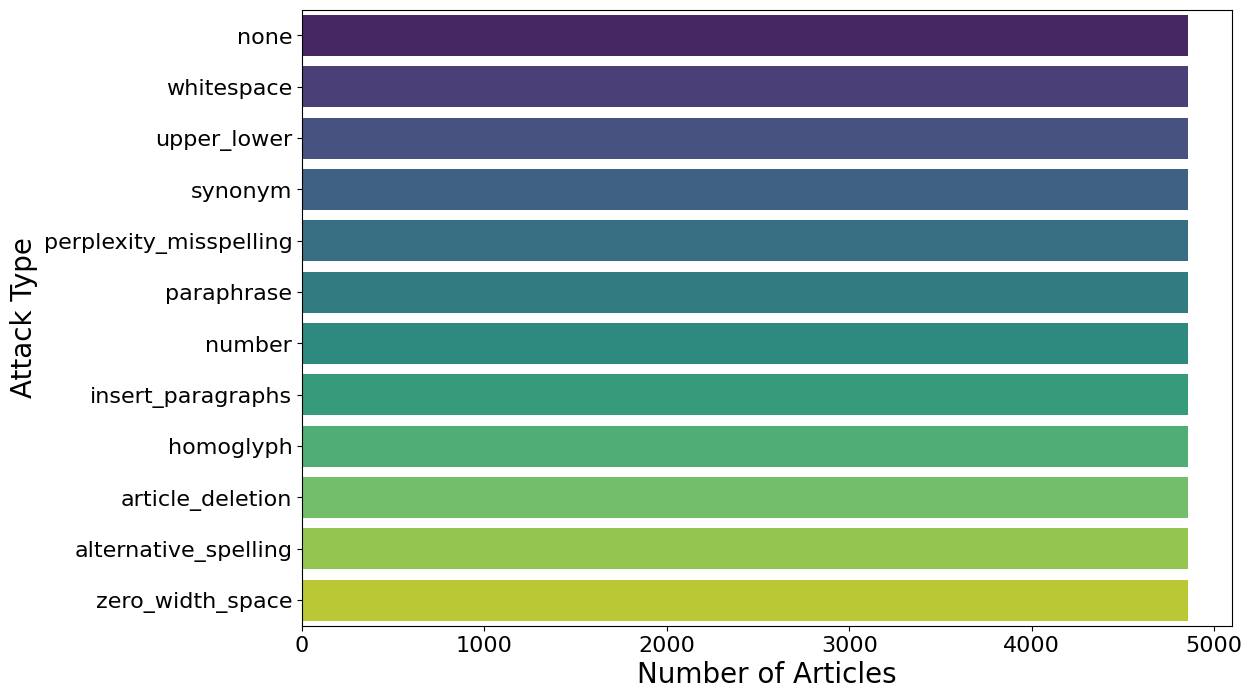

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import pandas as pd

# Load the raw test data
full_test = load_dataset('liamdugan/raid', split='extra')

# 1. Filter FIRST using the efficient .filter() method
# This operation is fast and doesn't load everything into memory.
attack_df_human_only = full_test.filter(lambda example: example['model'] == 'human')

# 2. Get the counts directly from the filtered dataset object
# This is still very fast.
attack_counts = pd.Series(attack_df_human_only['attack']).value_counts()

# 3. Create the final small DataFrame for plotting
plot_df = attack_counts.reset_index()
plot_df.columns = ['attack', 'count']


# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='attack', x='count', data=plot_df, order = plot_df['attack'], palette='viridis')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title('Distribution of Adversarial Attack Types in the Test Set')
plt.xlabel('Number of Articles', fontsize=20)
plt.ylabel('Attack Type', fontsize=20)
plt.savefig('attack_type_distribution.pdf', dpi=300, bbox_inches='tight')
plt.savefig('attack_type_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_19834/3518576156.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='attack', x='length', data=plot_df, palette='plasma')


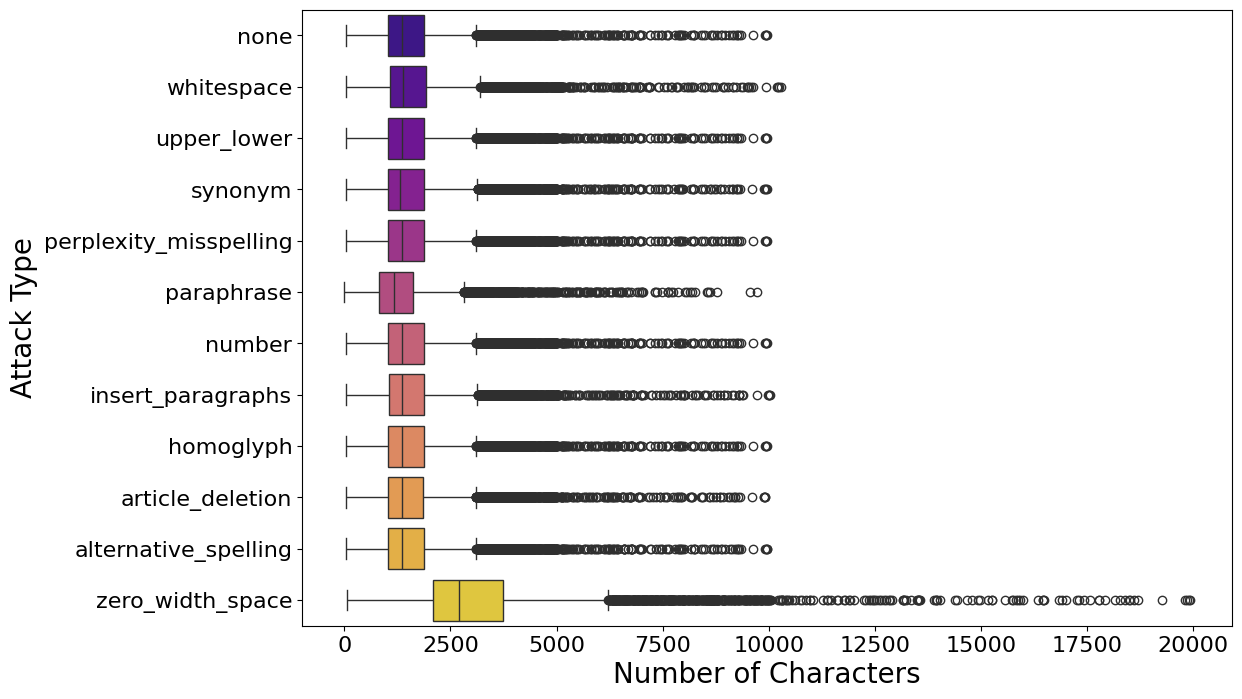

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import pandas as pd

# Load the raw test data
full_test = load_dataset('liamdugan/raid', split='extra')

# 1. Filter the dataset first to only include human-written text with attacks.
# This significantly reduces the data size before any other processing.
attack_data = full_test.filter(lambda example: example['model'] == 'human')

# 2. Use .map() to efficiently add the 'length' column to the filtered dataset.
def add_length(example):
    example['length'] = len(example['generation'])
    return example

attack_data_with_lengths = attack_data.map(add_length)

# 3. Convert the final, processed dataset to a DataFrame.
# This is fast because we've already filtered down to the exact data and
# columns ('attack', 'length') needed for the plot.
plot_df = attack_data_with_lengths.to_pandas()

# Plotting
plt.figure(figsize=(12, 8))
sns.boxplot(y='attack', x='length', data=plot_df, palette='plasma')
#plt.title('Text Length Distribution by Attack Type', fontsize=16)
plt.xlabel('Number of Characters', fontsize=20)
plt.ylabel('Attack Type', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Impact_of_Attacks.png', dpi=300, bbox_inches='tight')
plt.savefig('Impact_of_Attacks.pdf', dpi=300, bbox_inches='tight')
plt.show()

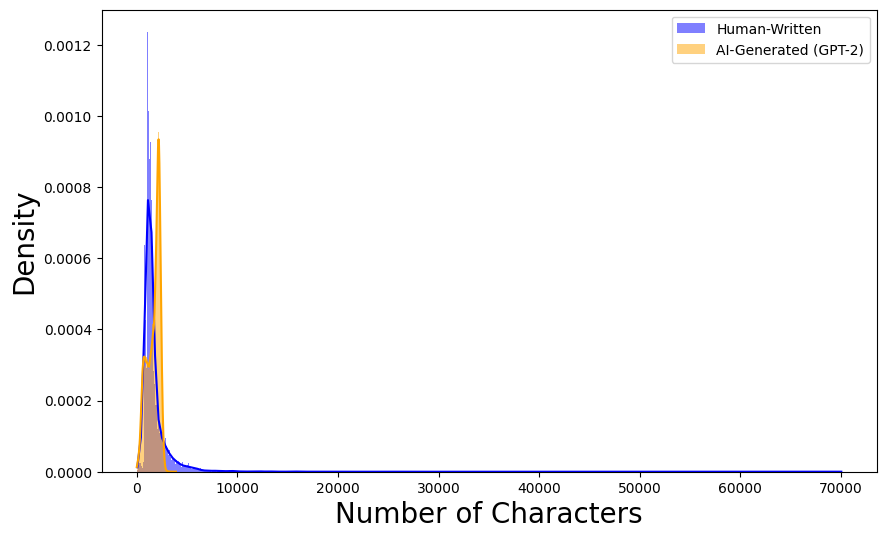

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import pandas as pd

# Load the raw training data
full_train = load_dataset('liamdugan/raid', split='train')

# 1. Use .map() to efficiently create a new 'length' column.
# This is fast as it leverages Apache Arrow and doesn't require Pandas.
def add_length(example):
    example['length'] = len(example['generation'])
    return example

data_with_lengths = full_train.map(add_length)

# 2. Filter the dataset to get only the rows you need.
# These operations are also highly optimized.
human_data = data_with_lengths.filter(lambda x: x['model']=='human' and x['attack']=='none')
ai_data = data_with_lengths.filter(lambda x: x['model']=='gpt2' and x['attack']=='none')

human_df = human_data.to_pandas()
ai_df = ai_data.to_pandas()

# Plotting
# We now use the DataFrames created above and specify the column with x='length'
plt.figure(figsize=(10, 6))
sns.histplot(data=human_df, x='length', color='blue', label='Human-Written', kde=True, stat="density", linewidth=0)
plt.legend(fontsize=25)
sns.histplot(data=ai_df, x='length', color='orange', label='AI-Generated (GPT-2)', kde=True, stat="density", linewidth=0)
#plt.title('Distribution of Text Length (Human vs. AI)')
plt.xlabel('Number of Characters', fontsize=20)
plt.ylabel('Density', fontsize=20)
plt.legend()
plt.savefig('text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig('text_length_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()